# Debugging with monkeys

This guide will demonstrate how `monkeys` can be used to discover and diagnose software bugs. By defining how you expect the components of your codebase to be able to interact and the invariants that should hold during those interactions, `monkeys` can find combinations for which these invariants do not hold. 

In this notebook, we'll be looking for bugs in a simple class which supports serialization to and deserialization from JSON. We want to make sure that under all circumstances, the class can be serialized without error, the JSON produced is valid, that instance properties are of the correct types, and that class-JSON-class round trips end up giving us the same object we had originally.

First, let's define our class.

In [1]:
from ast import literal_eval

class Dog(object):
    def __init__(self, name, age):
        self.name = name
        self.age = age
        
    def __eq__(self, other):
        if isinstance(other, Dog):
            return other.name == self.name and other.age == self.age
        
    def to_json(self):
        return '{{"name": "{0.name}", "age": "{0.age}"}}'.format(self)
    
    @classmethod
    def from_json(cls, json):
        data = literal_eval(json)
        return cls(
            name=data['name'],
            age=data['age']
        )

Now, let's import `monkeys` and start defining some constructs reflecting the properties we wanted to enforce (as stated above).

In [2]:
from monkeys import *

@params(str, int)
@rtype(Dog)
def new_dog(name, age):
    """Create a new dog from a name and age."""
    return Dog(name, age)
    
@params(Dog)
@rtype('JSON')
def dog_to_json(dog):
    """JSON produced can be deserialized into a Python dict."""
    json = dog.to_json()
    assert literal_eval(json), "`to_json` did not produce valid JSON."
    return json

@params('JSON')
@rtype(Dog)
def dog_from_json(json):
    """Dogs can be loaded in from the JSON we produce."""
    return Dog.from_json(json)
    
@params(Dog)
@rtype(Dog)
def dog_type_invariants(dog):
    """
    Constructs don't have to implement meaningful transformations - here, we 
    simply want to ensure at any time that Dog instances have string names and
    integer ages.
    """
    assert isinstance(dog.name, str), "`dog.name` was not a string."
    assert isinstance(dog.age, int), "`dog.age` was not an integer."
    return dog

@params(Dog)
@rtype(Dog)
def dog_round_trip(old_dog):
    """Serializing and deserializing a dog gives you the same dog."""
    new_dog = Dog.from_json(
        old_dog.to_json()
    )
    assert new_dog == old_dog, "Round-trip serialization did not preserve dog."
    return new_dog

We'll also need some example strings and integers, for `new_dog` to draw from.

In [3]:
names = [
    constant(str, "Fido"), 
    constant(str, "Rex"), 
    constant(str, "Pluto"),
]

ints = [
    constant(int, 5), 
    constant(int, 12), 
    constant(int, 1),
]

Now, let's visualize the type interactions we've declared, to ensure that everything looks OK:

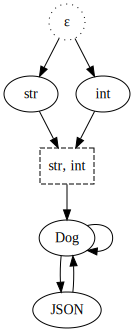

In [4]:
from monkeys.tools.display import type_graph
type_graph()

We might also want to add some additional interactions - e.g. allowing conversions from strings to integers (and vice-versa), or allowing use of JSON as a string - but for now, let's check that what we already have works. As we can see from the graph above, we can freely choose whether we want to generate Dog instances or JSON in order to test our system - let's choose Dog instances.

In [5]:
exception_percent = 0
for __ in xrange(100):
    try:
        build_tree(Dog).evaluate()
    except Exception:
        exception_percent += 1
        
exception_percent

41

Oh my - about half of the time, something goes wrong! Let's have `monkeys` diagnose under what circumstances we're seeing exceptions thrown.

In [6]:
from monkeys.tools.diagnostics import diagnose

diagnosis = diagnose(Dog)  # indicating the type we'd like to construct
diagnosis.show_report()

Discovered 2 distinct exceptions.
Reproducing exceptions...
Done.
AssertionError('`dog.age` was not an integer.',):
    3.68 | (dog_to_json) -> dog_from_json
    1.90 | (dog_from_json) -> dog_type_invariants
    1.66 | (dog_type_invariants) -> dog_type_invariants
AssertionError('Round-trip serialization did not preserve dog.',):
    2.44 | (new_dog) -> dog_round_trip
    1.58 | (dog_round_trip) -> dog_type_invariants
    1.36 | (_const_Rex, _const_12) -> new_dog


The diagnosis tool discovers exceptions encountered when evaluating trees and tries its best to reproduce them. From the report above, we can see the two exceptions occurring when building `Dog`, as well as the most common node combinations in trees where these exceptions occur. The first exception looks to be caused when we're deserializing a `Dog` from JSON, whereas, in the second case, round-trip serialization of new `Dog` instances is failing.

The diagnosis also catalogues the minimum reproducing examples it found for each exception. Let's visualize these with `node_graph`:

AssertionError('`dog.age` was not an integer.',)


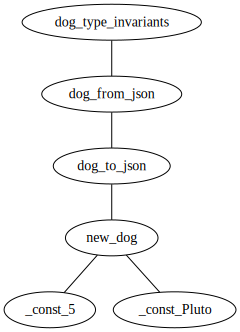

AssertionError('Round-trip serialization did not preserve dog.',)


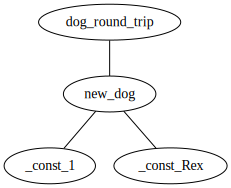

In [7]:
from monkeys.tools.display import node_graph
from IPython.display import display

for exception in diagnosis.exceptions:
    print exception
    repro = diagnosis.minimal_reproductions[exception]
    display(node_graph(repro))

We can clearly see that an integer is being passed in to `new_dog` as an age in both instances - but clearly not remaining one. Taking a look at `Dog.to_json`, the problem becomes obvious - we've put the dog's age in quotes! Let's quickly patch `Dog` with a new `to_json` method:

In [8]:
def fixed_to_json(self):
    return '{{"name": "{0.name}", "age": {0.age}}}'.format(self)

Dog.to_json = fixed_to_json

Now, let's run our diagnosis again:

In [9]:
diagnosis = diagnose(Dog)

UnsatisfiableConstraint: Could not find any exceptions after 250 trials.

Great - `diagnose` raises an exception to let us know that it couldn't find any issues. Now that we have identified and resolved that problem, let's allow the use of JSON as a string, revisualize our interactions, and see whether this leads to any additional bugs.

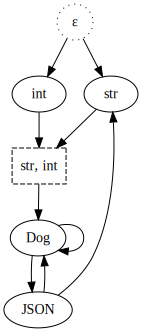

In [10]:
@params('JSON')
@rtype(str)
def json_to_str(json):
    return json  # We're already representing JSON as a string

type_graph()

In [11]:
diagnosis = diagnose(Dog)
diagnosis.show_report()

Discovered 22 distinct exceptions.
Reproducing exceptions...
Done.
SyntaxError('invalid syntax', ('<unknown>', 1, 16, '{"name": "{"name": "Pluto", "age": 5}", "age": 12}')):
    1.34 | (dog_to_json) -> dog_from_json
    0.98 | (dog_type_invariants) -> dog_round_trip
    0.96 | (new_dog) -> dog_to_json
SyntaxError('invalid syntax', ('<unknown>', 1, 16, '{"name": "{"name": "Rex", "age": 1}", "age": 1}')):
    1.80 | (dog_type_invariants) -> dog_type_invariants
    1.47 | (dog_to_json) -> dog_from_json
    1.05 | (new_dog) -> dog_to_json
SyntaxError('invalid syntax', ('<unknown>', 1, 16, '{"name": "{"name": "Pluto", "age": 1}", "age": 12}')):
    2.07 | (json_to_str, _const_12) -> new_dog
    2.07 | (dog_to_json) -> json_to_str
    1.86 | (new_dog) -> dog_to_json
SyntaxError('invalid syntax', ('<unknown>', 1, 16, '{"name": "{"name": "Pluto", "age": 12}", "age": 12}')):
    1.30 | (dog_to_json) -> dog_from_json
    0.99 | (dog_type_invariants) -> dog_type_invariants
    0.90 | (new_dog) ->

Something's clearly gone very wrong - let's see what a minimum reproduction looks like:

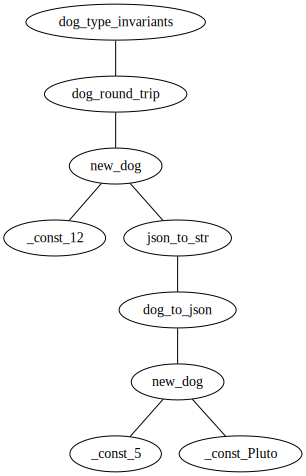

In [12]:
node_graph(diagnosis.minimal_reproductions.values()[0])

Ah - the problem's occurring when we deserialize a `Dog` instance that, itself, had a serialized `Dog` provided as a name. It's at this point that we might do some Googling and discover that Python provides perfectly good JSON serialization and deserialization out of the box:

In [13]:
import json

def fixed_fixed_to_json(self):
    return json.dumps({'name': self.name, 'age': self.age})

@classmethod
def fixed_from_json(cls, json_string):
    data = json.loads(json_string)
    return cls(
        name=str(data['name']),
        age=data['age']
    )

Dog.to_json = fixed_fixed_to_json
Dog.from_json = fixed_from_json

In [14]:
diagnose(Dog).show_report()

UnsatisfiableConstraint: Could not find any exceptions after 250 trials.

Again, the exception lets us know that our diagnosis tool couldn't find any issues.

While the use of `monkeys` for diagnosis may seem like overkill in our `Dog` example, in larger systems, bugs caused by specific combinations of components can be difficult to pin down - especially when these combinations are rare. The `monkeys` diagnostic tool allows us to hunt for these problematic combinations and gives us a means of confidently validating composability.

The diagnosis tool becomes even more powerful when combined with the Python code generation functionality of `monkeys`, covered in [Monkeys in abstract syntax trees](Monkeys%20in%20abstract%20syntax%20trees.ipynb) - using these methods, we can create and diagnosis issues directly in real Python code, and even integrate with existing test suites.